In [19]:
from sklearn.model_selection import train_test_split
import os
import seaborn as sns
import matplotlib.pyplot as plt
# é importante entender se seu problema é um problema de classificaçao ou de regressão => classificação
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
# acuracia é uma metrica apenas de classificação, se for regressão apenas o erro ja é a metrica
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
from imblearn.under_sampling import NearMiss,RandomUnderSampler
import numpy as np

drive_path = 'Database/'
contents = os.listdir(drive_path)

for dirname, _, filenames in os.walk(drive_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

df=pd.read_csv(drive_path + 'CVD_cleaned.csv')

Database/CVD_cleaned.csv


In [20]:
def metrics(y_test, y_pred):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for i in range(0, len(y_pred)):
        pred = y_pred[i]
        gt = y_test[i]
        if((1 == pred) and (pred == gt)):
            TP += 1
        elif((0 == pred) and (pred == gt)):
            TN += 1
        elif((1 == gt) and (pred != gt)):
            FN += 1
        elif((0 == gt) and (pred != gt)):
            FP += 1
    return TP,TN,FP,FN

def plot_confusion_matrix(TP, FP, FN, TN):
    aux_values = np.array([np.array([TP,FP]), np.array([FN, TN])]).astype(np.int64)
    aux_number = np.array([np.array([FN,TN]), np.array([TP, FP])]).astype(np.int64)
    
    #  0 1
    #  2 3
    
    #  2 3
    #  0 1

    size = 2

    x_start = 1.0
    x_end = 0.0
    y_start = 0.0
    y_end = 1.0

    extent = [x_start, x_end, y_start, y_end]

    fig = plt.figure()
    ax = fig.add_subplot(111)
    im = ax.imshow(aux_values, extent=extent, interpolation='None', cmap='viridis')

    # Add the text
    jump_x = (x_end - x_start) / (2.0 * size)
    jump_y = (y_end - y_start) / (2.0 * size)
    x_positions = np.linspace(start=x_start, stop=x_end, num=size, endpoint=False)
    y_positions = np.linspace(start=y_start, stop=y_end, num=size, endpoint=False)

    for y_index, y in enumerate(y_positions):
        for x_index, x in enumerate(x_positions):
            label = aux_number[y_index, x_index]
            text_x = x + jump_x
            text_y = y + jump_y
            ax.text(text_x, text_y, label, color='black', ha='center', va='center')

    ax.set(
                xticks=np.arange(2),
                yticks=np.arange(2),
                xlabel="True label",
                ylabel="Predicted label",
            )

    fig.colorbar(im)
    plt.show()
    plt.close()

In [21]:
# Vamos começar com os casos especiais

# Convertendo a categoria de diabete separadamente porque possui 4 strings, mas pode ser simplificado para booleano
def simplify_diabetes(diabetes_status):
    if "No" in diabetes_status:
        return 0
    elif "Yes" in diabetes_status:
        return 1

processed_df = df.copy()
processed_df['Diabetes'] = processed_df['Diabetes'].apply(simplify_diabetes)

# Checkup e Age_Category podem ser tratados por meio de Label Encoding
checkup_values = {
    'Never': 0,
    'Within the past year': 4,
    'Within the past 2 years': 3,
    'Within the past 5 years': 2,
    '5 or more years ago': 1
}

processed_df['Checkup'] = processed_df['Checkup'].map(checkup_values)

age_category_values = {
    '18-24': 1,
    '25-29': 2,
    '30-34': 3,
    '35-39': 4,
    '40-44': 5,
    '45-49': 6,
    '50-54': 7,
    '55-59': 8,
    '60-64': 9,
    '65-69': 10,
    '70-74': 11,
    '75-79': 12,
    '80+': 13
}

processed_df['Age_Category'] = processed_df['Age_Category'].map(age_category_values)

In [22]:
def binary_encoding(df, category, str1, str2):
  df[category].replace([str1, str2], [0, 1], inplace=True)
  return df

processed_df = binary_encoding(processed_df, "Heart_Disease", "No", "Yes")
processed_df = binary_encoding(processed_df, "Smoking_History", "No", "Yes")
processed_df = binary_encoding(processed_df, "Arthritis", "No", "Yes")
processed_df = binary_encoding(processed_df, "Depression", "No", "Yes")
processed_df = binary_encoding(processed_df, "Exercise", "No", "Yes")
processed_df = binary_encoding(processed_df, "Skin_Cancer", "No", "Yes")
processed_df = binary_encoding(processed_df, "Other_Cancer", "No", "Yes")
processed_df = binary_encoding(processed_df, "Smoking_History", "No", "Yes")

In [23]:
def one_hot_encoding(df, category):
  dummies = pd.get_dummies(df[category], prefix=category)
  df = pd.concat([df, dummies], axis='columns')
  df = df.drop([category], axis=1)
  return df

processed_df = one_hot_encoding(processed_df, "General_Health")
processed_df = one_hot_encoding(processed_df, "Sex")
processed_df.head()

,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Age_Category,Height_(cm),...,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption,General_Health_Excellent,General_Health_Fair,General_Health_Good,General_Health_Poor,General_Health_Very Good,Sex_Female,Sex_Male
0,3,0,0,0,0,0,0,1,11,150.0,...,30.0,16.0,12.0,0,0,0,1,0,1,0
1,4,0,1,0,0,0,1,0,11,165.0,...,30.0,0.0,4.0,0,0,0,0,1,1,0
2,4,1,0,0,0,0,1,0,9,163.0,...,12.0,3.0,16.0,0,0,0,0,1,1,0
3,4,1,1,0,0,0,1,0,12,180.0,...,30.0,30.0,8.0,0,0,0,1,0,0,1
4,4,0,0,0,0,0,0,0,13,191.0,...,8.0,4.0,0.0,0,0,1,0,0,0,1


In [24]:
#Unindo as colunas de General Health em uma só
# poor = 1
# fair = 2
# good = 3
# very_good = 4
# excellent = 5

neural_df = processed_df.copy()
neural_df.insert(loc=17, column='General_Health', value=-1)
neural_df.insert(loc=23, column='Sex', value=-1)

neural_df.loc[neural_df["General_Health_Poor"] == True, "General_Health"] = 1
neural_df.loc[neural_df["General_Health_Fair"] == True, "General_Health"] = 2
neural_df.loc[neural_df["General_Health_Good"] == True, "General_Health"] = 3
neural_df.loc[neural_df["General_Health_Very Good"] == True, "General_Health"] = 4
neural_df.loc[neural_df["General_Health_Excellent"] == True, "General_Health"] = 5

# Unindo as colunas de sexo numa só
# Female = 0
# Male = 1

neural_df.loc[neural_df["Sex_Female"] == True, "Sex"] = 1
neural_df.loc[neural_df["Sex_Male"] == True, "Sex"] = 0

del neural_df["General_Health_Poor"]
del neural_df["General_Health_Fair"]
del neural_df["General_Health_Good"]
del neural_df["General_Health_Very Good"]
del neural_df["General_Health_Excellent"]

del neural_df["Sex_Female"]
del neural_df["Sex_Male"]


neural_df.head()

,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption,General_Health,Sex
0,3,0,0,0,0,0,0,1,11,150.0,32.66,14.54,1,0.0,30.0,16.0,12.0,1,1
1,4,0,1,0,0,0,1,0,11,165.0,77.11,28.29,0,0.0,30.0,0.0,4.0,4,1
2,4,1,0,0,0,0,1,0,9,163.0,88.45,33.47,0,4.0,12.0,3.0,16.0,4,1
3,4,1,1,0,0,0,1,0,12,180.0,93.44,28.73,0,0.0,30.0,30.0,8.0,1,0
4,4,0,0,0,0,0,0,0,13,191.0,88.45,24.37,1,0.0,8.0,4.0,0.0,3,0


In [25]:
#define qual a coluna alvo e a coluna de dados
y = neural_df["Heart_Disease"] #output esperado
neural_df.drop("Heart_Disease", inplace=True, axis=1) #todo o restante
X = neural_df

# divide o dataset em treino e teste
# o random size é referente a seed inicial, para fazer outros testes sempre com a mesma base (sempre vai dar o mesmo resultado com o dataframe usado)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(random_state=42)

model.fit(X_train, y_train) #treina o modelo



DecisionTreeClassifier(random_state=42)

1159 52015 4759 3838
Accuracy:  0.8608246588204821
Recall:  0.23193916349809887
Precision:  0.19584319026698208


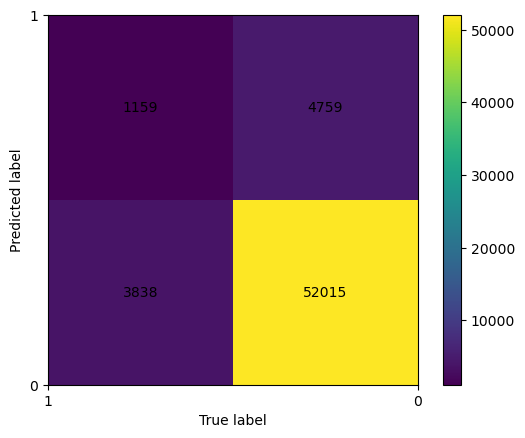

In [26]:
predicted = model.predict(X_test) #predicao (f(x))

TP,TN,FP,FN = metrics(y_test.to_numpy(), predicted)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
accuracy = (TN+TP)/(TP+FP+FN+TN)
print(TP,TN,FP,FN)
print("Accuracy: ", accuracy)
print("Recall: ", recall)
print("Precision: ", precision)
plot_confusion_matrix(TP,FP,FN,TN)

#### Podemos perceber que há um desequilíbrio no dataset: há muito mais pessoas que não possuem/ já possuíram doenças cardiovasculares do que pessoas que possuem/já possuíram. Comprovando o desequilíbrio:

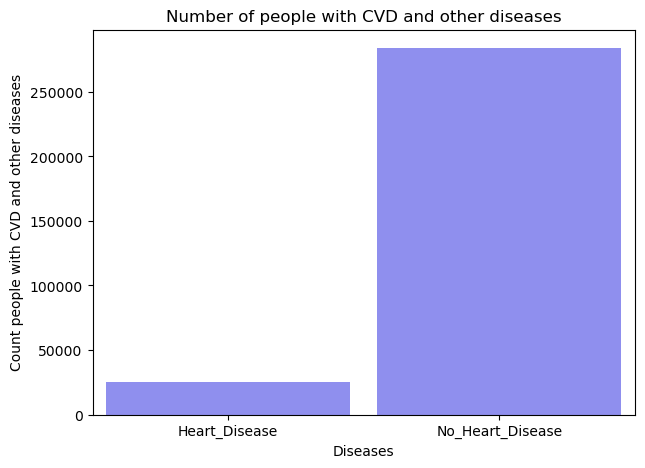

In [27]:
def graficoDiseaseCVD(tabela):
    '''Funcao que retorna um grafico de barras com a
    quantidade de pessoas em cada categoria de comorbidade a partir de uma tabela'''
    keys = ["Heart_Disease"]
    values = {}
    for key in keys:
        values[key] = len(tabela.query(f'{key} == "Yes"'))
        values['No_'+key] = len(tabela.query(f'{key} == "No"'))
    fig = plt.figure(figsize=(7,5))
    a,b = (zip(*values.items()))
    return list(a), list(b)

CVDDisease, countCVDDisease = graficoDiseaseCVD(df)
ax=sns.barplot(x=CVDDisease,y=countCVDDisease,color = 'blue', alpha = 0.5, width=0.9)
plt.title("Number of people with CVD and other diseases")
ax.set(xlabel="Diseases", ylabel="Count people with CVD and other diseases")

plt.show()

#### Vamos reselecionar os dados para treino:

In [28]:
rus = RandomUnderSampler(random_state=0)
underX, undery =rus.fit_resample(X_train, y_train)

In [29]:
_model = DecisionTreeClassifier(random_state=42)
_model.fit(underX, undery) #treina o modelo

DecisionTreeClassifier(random_state=42)

Accuracy:  0.663709507697787
Recall:  0.6539923954372624
Precision:  0.1464682681964862


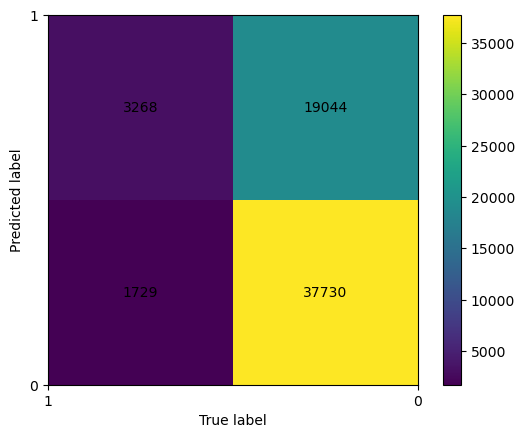

In [30]:
predicted = _model.predict(X_test) #predicao (f(x))

TP,TN,FP,FN = metrics(y_test.to_numpy(), predicted)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
accuracy = (TN+TP)/(TP+FP+FN+TN)
print("Accuracy: ", accuracy)
print("Recall: ", recall)
print("Precision: ", precision)
plot_confusion_matrix(TP,FP,FN,TN)

#### Podemos perceber que, mesmo com o dataset equilibrado, a árvore de decisão parece afetada de forma negativa. Portanto, não é o melhor modelo para a predição.

# Redes Neurais de predição de cada risco de CVD em relação aos hábitos dos pacientes

In [31]:
import tensorflow as tf
import numpy as np

# renomeando os dados de treino e de teste para o dados reselecionados
x_train = underX.to_numpy()
x_train = x_train.astype(np.float32)
y_train = undery.to_numpy()
y_train = y_train.astype(np.float32)

x_test = X_test.to_numpy()
x_test = x_test.astype(np.float32)
y_test = y_test.to_numpy()
y_test = y_test.astype(np.float32)


In [52]:
input_layer = tf.keras.layers.Input(shape=(18))

x = input_layer
x = tf.keras.layers.Dense(64, kernel_initializer='uniform', activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)

out_layer = tf.keras.layers.Dense(1, kernel_initializer='uniform', activation='sigmoid')(x)

model = tf.keras.Model(input_layer, out_layer)
optimizer=tf.keras.optimizers.Adam(0.0001)
loss = tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True)

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])

model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 18)]              0         
                                                                 
 dense_17 (Dense)            (None, 64)                1216      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1281 (5.00 KB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
model.fit(x_train, y_train, validation_split=0.20, epochs=100, batch_size=128, verbose=1)

Epoch 1/100
250/250 [==============================] - 2s 3ms/step - loss: 0.0845 - accuracy: 0.6060 - val_loss: 0.1128 - val_accuracy: 0.0000e+00
Epoch 2/100
250/250 [==============================] - 1s 3ms/step - loss: 0.0675 - accuracy: 0.6263 - val_loss: 0.0992 - val_accuracy: 0.0000e+00
Epoch 3/100
250/250 [==============================] - 1s 3ms/step - loss: 0.0622 - accuracy: 0.6270 - val_loss: 0.0943 - val_accuracy: 0.0000e+00
Epoch 4/100
250/250 [==============================] - 1s 2ms/step - loss: 0.0589 - accuracy: 0.6300 - val_loss: 0.0908 - val_accuracy: 5.0063e-04
Epoch 5/100
250/250 [==============================] - 1s 2ms/step - loss: 0.0565 - accuracy: 0.6380 - val_loss: 0.0843 - val_accuracy: 0.0329
Epoch 6/100
250/250 [==============================] - 1s 2ms/step - loss: 0.0549 - accuracy: 0.6491 - val_loss: 0.0857 - val_accuracy: 0.0574
Epoch 7/100
250/250 [==============================] - 1s 3ms/step - loss: 0.0539 - accuracy: 0.6585 - val_loss: 0.0795 - val_

In [54]:
y_pred = model.predict(x_test)
y_pred[y_pred >= 0.5] = 1.
y_pred[y_pred < 0.5] = 0.

1931/1931 [==============================] - 2s 1ms/step


Accuracy:  0.9007624937268297
Recall:  0.3087852711626976
Precision:  0.3657264754681204


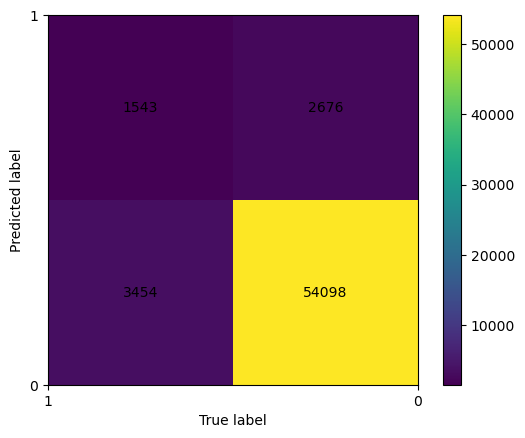

In [55]:
TP,TN,FP,FN = metrics(y_test, y_pred)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
accuracy = (TN+TP)/(TP+FP+FN+TN)
print("Accuracy: ", accuracy)
print("Recall: ", recall)
print("Precision: ", precision)
plot_confusion_matrix(TP,FP,FN,TN)